In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
from skimage.filters import gabor_kernel
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("tf")
from skimage.color import rgb2gray
from scipy import ndimage as ndi
 
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

Using TensorFlow backend.


As a good practice suggests, we need to declare our variables:
- batch_size – the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you’ll need
- num_classes – number of cifar-10 data set classes
- one epoch – one forward pass and one backward pass of all the training examples


In [34]:
batch_size = 32
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch

num_classes = 10
epochs = 24
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [35]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Print figure with 10 random images from dataset

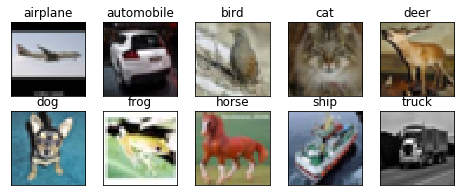

In [36]:
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Convert to Grayscale images

In [37]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    return rst

In [38]:
unique, count = np.unique(y_train[:5000], return_counts=True)
print(count)

[505 460 519 486 519 488 519 486 520 498]


In [39]:
train_selected_amount = 5000
test_selected_amount = 1000
gray_x_train = grayscale(x_train[:selected_amount])
gray_x_test = grayscale(x_test[:test_selected_amount])
y_train = np_utils.to_categorical(y_train[:selected_amount], num_classes)
y_test = np_utils.to_categorical(y_test[:test_selected_amount], num_classes)
print(y_train.shape)
print(y_test.shape)


(5000, 10)
(1000, 10)


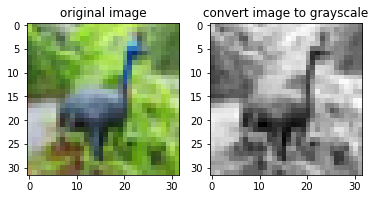

In [12]:
first_img = gray_x_train[6]
original_img = x_train[6]

plt.figure()
plt.subplot(121)
plt.title('original image')
plt.imshow(original_img)
plt.subplot(122)
plt.title('convert image to grayscale')
plt.imshow(first_img, cmap='gray')
plt.show()

In [13]:
def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    real_part = ndi.convolve(image, np.real(kernel), mode='wrap')
    imagine_part = ndi.convolve(image, np.imag(kernel), mode='wrap')
    return {'real_part': real_part, 'imagine_part': imagine_part}
    # return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
    #                ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

In [14]:
def convolve(images):
    orientation_spread = np.linspace(0, 4, 8) / 4. * np.pi
    scales = np.linspace(0.1, 0.4, 6)
    real_list = []
    imagine_list = []
    kernels = []
    kernel_params = []
    for theta in orientation_spread:
        for frequency in scales:
            kernel = gabor_kernel(frequency, theta=theta)
            kernels.append(kernel)
            params = 'theta=%d, frequency=%.2f' % (theta * 180 / np.pi, frequency)
            kernel_params.append(params)
            # Save kernel and the power image for each image
            real_list.append([power(img, kernel)['real_part'] for img in images])
            imagine_list.append([power(img, kernel)['imagine_part'] for img in images])
    real_list = np.array(real_list)
    imagine_list = np.array(imagine_list)
    stacked_list = np.vstack((real_list, imagine_list))
    return stacked_list, kernels, kernel_params

In [15]:
# print(gray_x_train[0,:].shape)
results_train, kernels, kernel_params= convolve(gray_x_train)
convolved_x_test, kernels, kernel_params= convolve(gray_x_test)

#### previous batch took ~40 min to convole (4 ** 50000 * 32 * 32)
#### Current batch took 6 hour to convolve (48 ** 50000 * 32 * 32)
#### started at 21:32

In [16]:
convolved_results = results_train
# convolved_x_test = convolved_x_test
print(convolved_results.shape)

(96, 5000, 32, 32)


In [29]:
# print('orientations (x axis):')
# # print(orientation_spread)
# print()
# print('scales (y axis):')
# print(scales)
# # print(kernels[0])
# print(results.shape[1:])

NameError: name 'test_selected_amount' is not defined

(96, 32, 32)


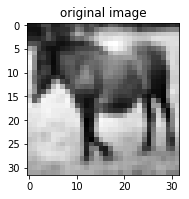

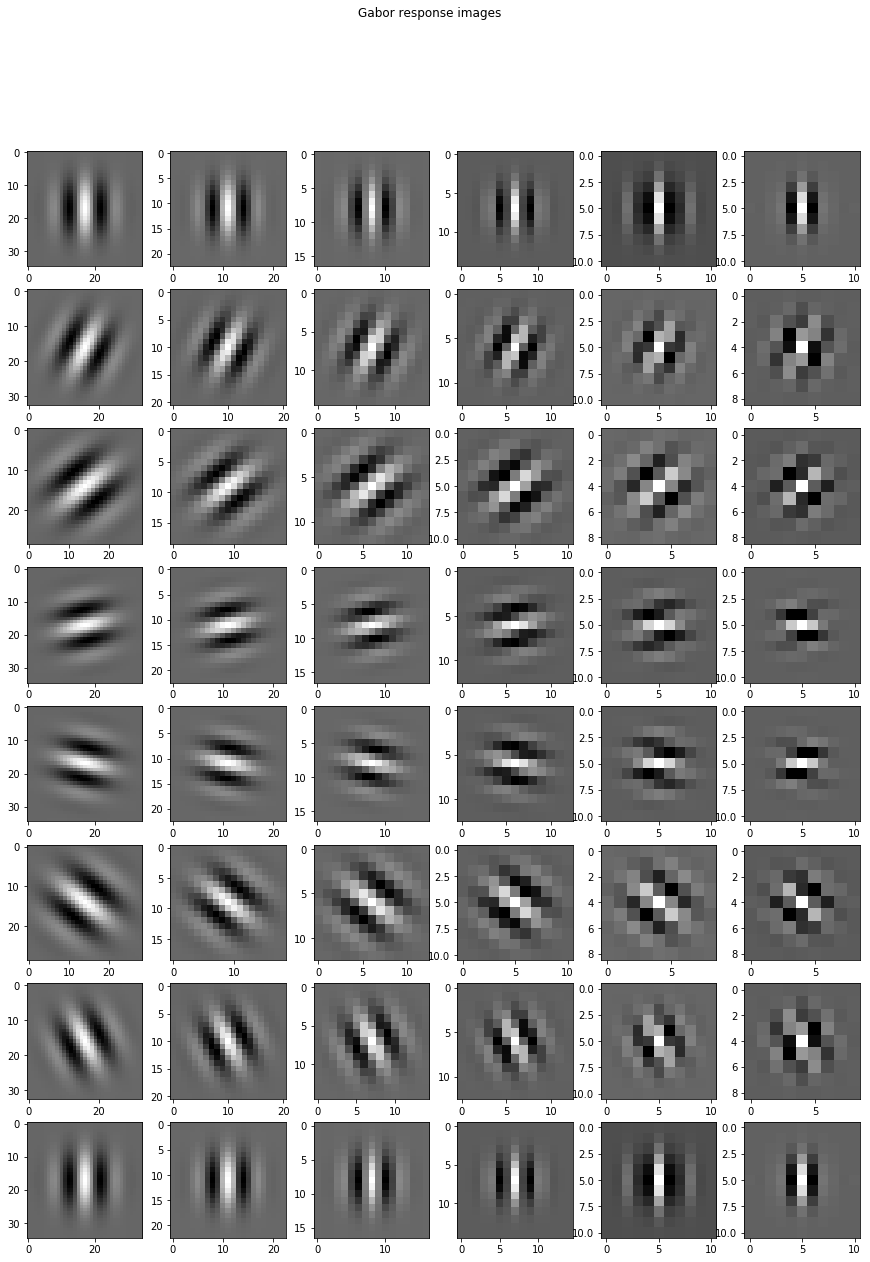

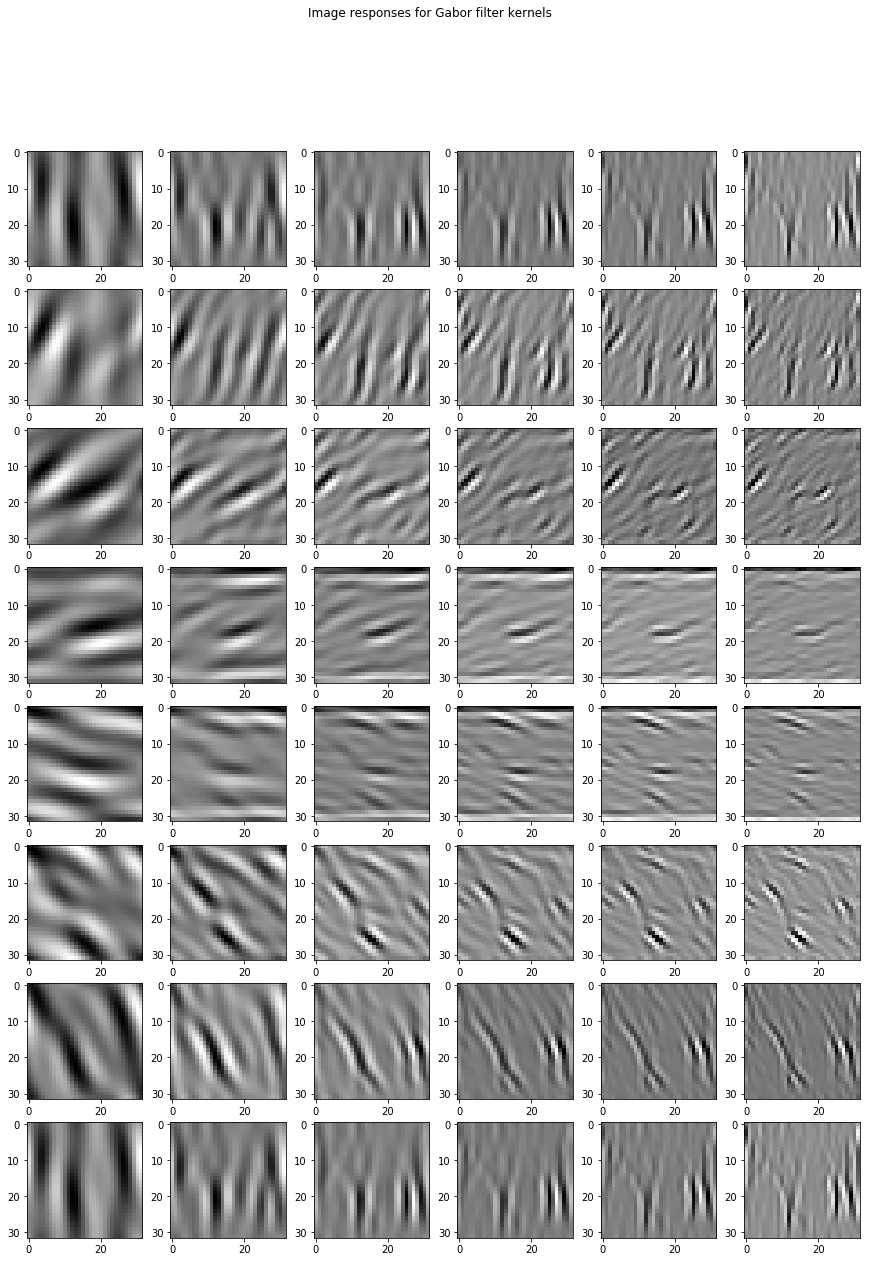

In [19]:
selected = 7
test = results_train[:, selected, ::]
print(test.shape)

plt.figure()
plt.subplot(121)
plt.title('original image')
plt.imshow(gray_x_train[selected], cmap='gray')

fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15, 20))
plt.gray()
fig.suptitle('Gabor response images', fontsize=12)
idx = 0
for row in range(0, 8):
    for col in range(0, 6):
        cell = axes[row][col]
        cell.imshow(np.real(kernels[idx]))
        idx += 1

fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(15, 20))
plt.gray()
fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
idx = 0
for row in range(0, 8):
    for col in range(0, 6):
        cell = axes[row][col]
        cell.imshow(test[idx, ::])
        idx += 1

In [21]:
np.save('convolved_96_real_imagine', results_train)

## Pre-processing for Neural Network
- Cast to float32
- Scale to range 0 - 1

In [23]:
# y_train = np_utils.to_categorical(y_train[:5000], num_classes)
# y_test = np_utils.to_categorical(y_test, num_classes)
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train  /= 255
# x_test /= 255

# x_train = x_train[:25000,::]
# print(x_train.shape[1:])

convolved_results = np.array(results_train)
print(convolved_results.shape)
convolved_results = np.einsum('abcd->bcda', convolved_results)
convolved_x_test = np.einsum('abcd->bcda', convolved_x_test)
print(convolved_results.shape)


(96, 5000, 32, 32)
(5000, 32, 32, 96)


We will use a model with 4 convolutional layers followed by max pooling and a flattening out the network to fully connected layers to make predictions:
1. Conv input layer, 32 feature maps with a size of 3x3, a rectifier activation function
2. Cov input layer, 32 (same as 1)
3. Max Pool layer with size 2x2
4. Dropout set to 25%
5. Conv input layer, 64 feature maps with a size of 3x3, a rectifier activation fuction
6. Conv input layer, 64 feature maps with a size of 3x3, ...
7. Max Pool layer with size 2x2
8. Dropout set to 25%
9. Flatten layer
10. Fully connected layer with 512 units and a rectifier activation function
11. Dropout set to 50%
12. Fully connected output layer with 10 units and a softmax activation function
***
SGD optimization algorithm and weight decay start with a learning rate of 0.1
***
Then we can fit this model with 100 epochs and a batch size of 32

## Custom initializer

In [ ]:
def custom_gabor(shape, dtype=None):
    kernels = []
    for theta in (0, 1):
        theta = theta / 4. * np.pi
        for frequency in (0.1, 0.4):
            kernel = gabor_kernel(frequency, theta=theta)
            print(type(kernel))
            kernels.append(kernel)
    kernels = np.array(kernels)
    print(kernels.shape)
    return K.variable(kernels, dtype=dtype)

In [24]:
def base_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', data_format='channels_last', input_shape=convolved_results.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    # sgd = SGD(lr = 0.1, decay = 1e-6, momentum=0.9, nesterov=True)
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    # Train model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [40]:
print(y_train.shape)
cnn_n = base_model()
print(convolved_results.shape)
print(convolved_x_test.shape)
cnn_n.summary()

cnn = cnn_n.fit(convolved_results, y_train, batch_size=batch_size, epochs=epochs, validation_data=(convolved_x_test, y_test), shuffle=True)

(5000, 10)
(5000, 32, 32, 96)
(1000, 32, 32, 96)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        27680     
_________________________________________________________________
activation_31 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)         

In [41]:
# Vizualizing model structure

sequential_model_to_ascii_printout(cnn_n)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32   96
              Conv2D    \|/  -------------------     27680     2.2%
                relu   #####     32   32   32
              Conv2D    \|/  -------------------      9248     0.7%
                relu   #####     30   30   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     15   15   32
             Dropout    | || -------------------         0     0.0%
                       #####     15   15   32
              Conv2D    \|/  -------------------     18496     1.4%
                relu   #####     15   15   64
              Conv2D    \|/  -------------------     36928     2.9%
                relu   #####     13   13   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      6    6   64
             Dropout    | || -------------------         0     0.0%
              

## Evaluation

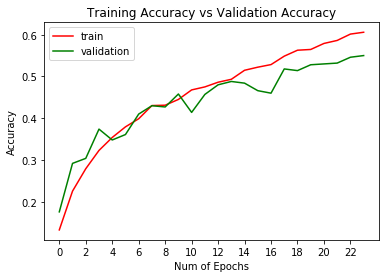

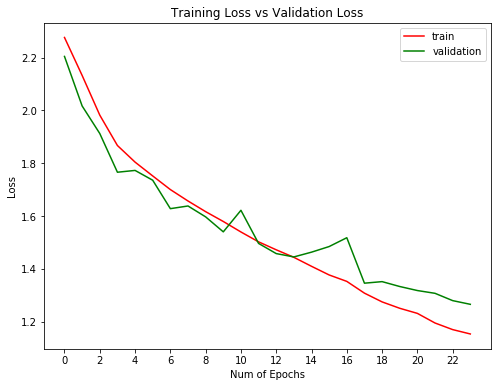

In [42]:
# Plots for training and testing process: loss and accuracy

plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])


plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()

In [43]:
score = cnn_n.evaluate(convolved_x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.265409191131592
Test accuracy: 0.55
